In [ ]:
#####################
## Bitcoin (BTC)   ##
#####################

# **Optimized LSTM**


In [ ]:
!pip install tensorflow
!pip install numpy
!pip install pandas

In [ ]:
#######################
###### Libraries ######
#######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Set 3 seeds and record the model performance for each : 42, 45, 91
# Best seed 42
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load dataset without scaling

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BTC_noscale.csv')
data.drop(columns=['Crypto', 'Open', 'High', 'Low'], inplace=True)
data.head()

,Date,Close
0,2018-01-01,13535.0
1,2018-01-02,14770.0
2,2018-01-03,15057.0
3,2018-01-04,14921.0
4,2018-01-05,16828.0


In [ ]:
#################
####  Input  ####
#################

# ----------------------
# Step 1 — Normalization
# ----------------------

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values.reshape(-1, 1))
data_scaled = pd.concat([data[['Date']].reset_index(drop=True), pd.DataFrame(scaled_data, columns=['Close'])],axis=1)


# -------------------------
# Step 2 — Train/Test split
# -------------------------

n_samples= len(scaled_data)
train_end = int(0.65 * n_samples)
val_end   = train_end + int(0.10 * n_samples)
input = scaled_data.reshape(-1)

# Train/validation/test slices
train_slice = input[:train_end]
val_slice   = input[train_end:val_end]
test_slice  = input[val_end:]

window = 120

In [ ]:
# -------------------------------
# Step 3 — Create Sliding Windows
# -------------------------------

def sequence(data, window_size):

    data = np.asarray(data)
    data = data.reshape(-1, 1)
    T = data.shape[0]

    x = []
    y = []
    for i in range(window_size, T):
        x.append(data[i-window_size:i])
        y.append(data[i])

    x = np.array(x)
    y = np.array(y)
    return x, y

# Create Windowed sequences
x_train, y_train = sequence(train_slice, window)
x_val,   y_val   = sequence(val_slice,   window)
x_test,  y_test  = sequence(test_slice,  window)

print("x_train shape:", x_train.shape)
print("x_val shape:  ", x_val.shape)
print("x_test shape: ", x_test.shape)
print('y_train shape:', y_train.shape)
print('y_validation shape:', y_val.shape)
print('y_test shape:', y_test.shape)


x_train shape: (1165, 120, 1)
x_val shape:   (77, 120, 1)
x_test shape:  (375, 120, 1)
y_train shape: (1165, 1)
y_validation shape: (77, 1)
y_test shape: (375, 1)


In [ ]:
# ------------------------
# Step 4 — LSTM Input
# ------------------------

act_func = 'tanh'
n_timesteps = x_train.shape[1]
n_features = x_train.shape[2]

# ---------------------------
# Step 5 — LSTM structure
# ---------------------------

lstm = Sequential()
lstm.add(LSTM(64, input_shape=(n_timesteps,n_features), return_sequences=True, activation=act_func))
lstm.add(LSTM(16, return_sequences=True, activation=act_func))
lstm.add(LSTM(2, return_sequences=False, activation=act_func))
lstm.add(Dense(1, activation='linear'))

# ----------------------------------
# Step 6 — Compile Model/Regression
# ----------------------------------

# MSE loss
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', RootMeanSquaredError(), 'mape']);


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# --------------------
# Step 7 — Training
# --------------------

history = lstm.fit(x_train, y_train,
                   epochs=120, batch_size=32,
                   validation_data=(x_val, y_val),
                   verbose=2)

Epoch 1/120
37/37 - 5s - 146ms/step - loss: 0.0109 - mae: 0.0676 - mape: 34155.1562 - root_mean_squared_error: 0.1044 - val_loss: 0.0070 - val_mae: 0.0620 - val_mape: 7.7696 - val_root_mean_squared_error: 0.0835
Epoch 2/120
37/37 - 1s - 17ms/step - loss: 0.0018 - mae: 0.0236 - mape: 4849.2329 - root_mean_squared_error: 0.0423 - val_loss: 0.0043 - val_mae: 0.0548 - val_mape: 7.4013 - val_root_mean_squared_error: 0.0657
Epoch 3/120
37/37 - 1s - 16ms/step - loss: 0.0015 - mae: 0.0211 - mape: 12392.6279 - root_mean_squared_error: 0.0381 - val_loss: 0.0032 - val_mae: 0.0474 - val_mape: 6.5041 - val_root_mean_squared_error: 0.0563
Epoch 4/120
37/37 - 1s - 16ms/step - loss: 0.0014 - mae: 0.0205 - mape: 6376.0562 - root_mean_squared_error: 0.0369 - val_loss: 0.0026 - val_mae: 0.0395 - val_mape: 5.2228 - val_root_mean_squared_error: 0.0512
Epoch 5/120
37/37 - 1s - 16ms/step - loss: 0.0013 - mae: 0.0202 - mape: 6188.3618 - root_mean_squared_error: 0.0359 - val_loss: 0.0025 - val_mae: 0.0380 - va

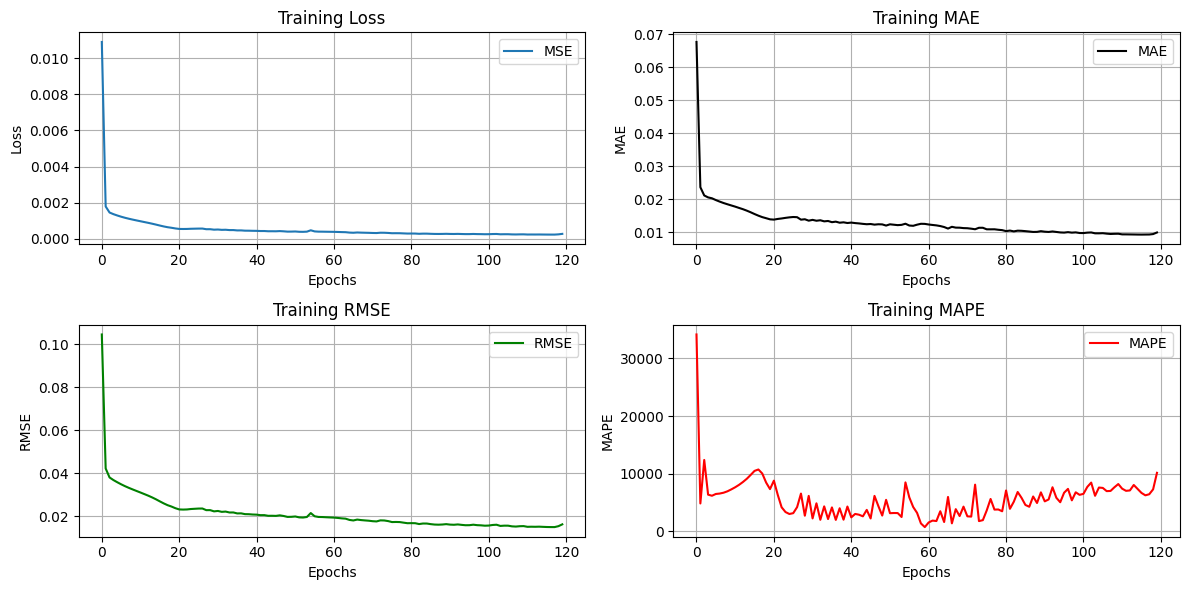

In [ ]:
####################
### Plot Results ###
####################

# Training MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['loss'], label='MSE')
ax[0, 0].set_title('Training Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0, 0].grid(True)

# Training MAE
ax[0, 1].plot(history.history['mae'], label='MAE', color='black')
ax[0, 1].set_title('Training MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()
ax[0, 1].grid(True)

# Training RMSe
ax[1, 0].plot(history.history['root_mean_squared_error'], label='RMSE', color='green')
ax[1, 0].set_title('Training RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1, 0].grid(True)

# Training MAPE
ax[1, 1].plot(history.history['mape'], label='MAPE', color='red')
ax[1, 1].set_title('Training MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

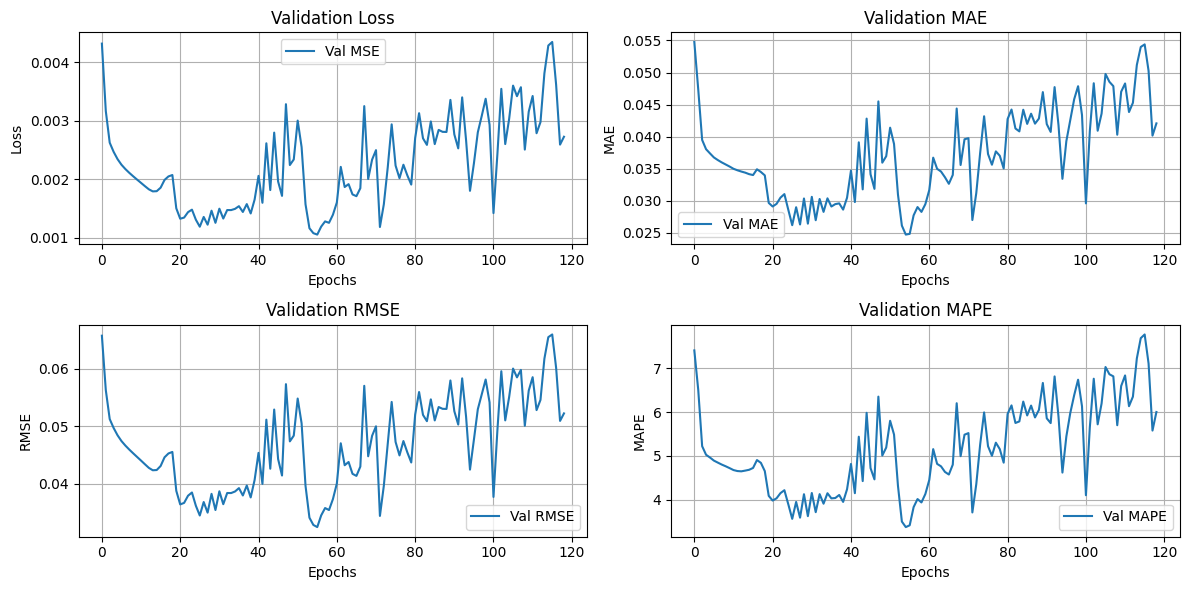

In [ ]:
# Validation MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['val_loss'][1:], label='Val MSE')
ax[0, 0].set_title('Validation Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0,0].grid(True)

# Validation MAE
ax[0, 1].plot(history.history['val_mae'][1:], label='Val MAE')
ax[0, 1].set_title('Validation MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()
ax[0,1].grid(True)

# Validation RMSE
ax[1, 0].plot(history.history['val_root_mean_squared_error'][1:], label='Val RMSE')
ax[1, 0].set_title('Validation RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1,0].grid(True)


# Validation MAPE
ax[1, 1].plot(history.history['val_mape'][1:], label='Val MAPE')
ax[1, 1].set_title('Validation MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Store best training/validation metrics
# Training
train_mse = history.history['loss']
best_epoch = np.argmin(train_mse)
best_train_mse = train_mse[best_epoch]
best_train_rmse = history.history['root_mean_squared_error'][best_epoch]
best_train_mae  = history.history['mae'][best_epoch]
best_train_mape = history.history['mape'][best_epoch]

# Validation: record epoch at which validation loss is the lowest for each seed
val_mse = history.history['val_loss']
best_epoch = np.argmin(val_mse)
best_val_mse = val_mse[best_epoch]
best_val_rmse = history.history['val_root_mean_squared_error'][best_epoch]
best_val_mae  = history.history['val_mae'][best_epoch]
best_val_mape = history.history['val_mape'][best_epoch]

In [ ]:
# -------------------------
# Step 8 — Predict/Testing
# -------------------------

y_predict= lstm.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [ ]:
# -----------------------------------
# Step 9 — Test MSE/RMSE/MAE/MAPE/R2
# -----------------------------------

# Compute the loss metrics
test_mse = mean_squared_error(y_test, y_predict)
test_rmse = root_mean_squared_error(y_test, y_predict)
test_mae = mean_absolute_error(y_test, y_predict)
test_mape = mean_absolute_percentage_error(y_test, y_predict)
test_r2_score = r2_score(y_test, y_predict)

print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Mean Absolute Error:", test_mae)
print("Mean Absolute Percentage Error:", test_mape)
print("R2 Score:", test_r2_score)

Mean Squared Error: 0.0005838094314968458
Root Mean Squared Error: 0.02416214873509485
Mean Absolute Error: 0.019349606609793665
Mean Absolute Percentage Error: 0.06567359849556961
R2 Score: 0.8617101527342049


In [ ]:
#-------------------------------------------------
# Step 10 - Inverse scaling: original price scale
#-------------------------------------------------

y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_predict_orig = scaler.inverse_transform(y_predict)


In [ ]:
y_test.shape

(375, 1)

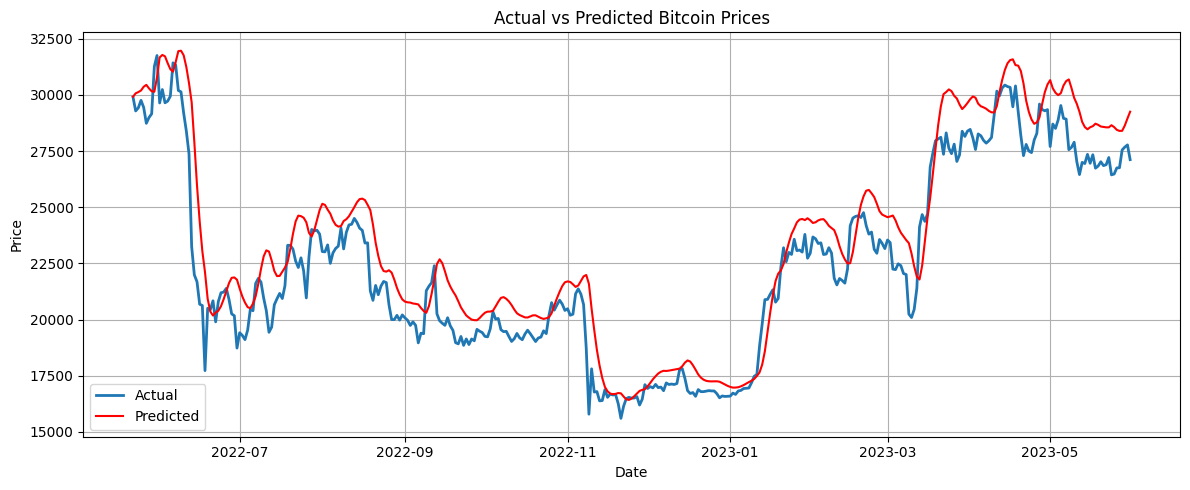

In [ ]:
#----------------------------------------------
# Step 11 - Plot prediction vs. actuals prices
#----------------------------------------------

# Add window size to test idx
start_index = 1482 + 120
# Test set dates range + convert to datetime
dates = data['Date'].iloc[start_index:start_index + len(y_test_orig)].reset_index(drop=True)
dates = pd.to_datetime(dates)

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 5))
plt.plot(dates, y_test_orig, label='Actual', linewidth=2)
plt.plot(dates, y_predict_orig, label='Predicted', color='red')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#--------------------------
# Step 12 - Export results
#--------------------------

# Export prediction dataset
predictions_df = pd.DataFrame({
    'Date': dates,
    'Actual': y_test_orig.flatten(),
    'Predicted': y_predict_orig.flatten()
})

predictions_df.to_csv('BTC_lstm_predictions.csv', index=False)

from google.colab import files
files.download('BTC_lstm_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Store metrics in dataframe along with best training/validation loss (record epoch)
results = {
    "seed": 91,
    "best_epoch": best_epoch + 1,    # best validation epoch
    "train_mse": best_train_mse,
    "train_rmse": best_train_rmse,
    "train_mae": best_train_mae,
    "train_mape": best_train_mape,
    "val_mse": best_val_mse,
    "val_rmse": best_val_rmse,
    "val_mae": best_val_mae,
    "val_mape": best_val_mape,
    "test_mse": test_mse,
    "test_rmse": test_rmse,
    "test_mae": test_mae,
    "test_mape": test_mape,
    "test_r2_score": test_r2_score
}

btc_results = pd.DataFrame([results])
btc_results.to_csv('btc_lstm_results.csv')

files.download('btc_lstm_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Export loss results
loss_results = pd.DataFrame(history.history)
loss_results.to_csv('loss_btc_results.csv')

files.download('loss_btc_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Regime Classification**

In [ ]:
# ------------------------------------------
# Step 1 — Compute Log returns & Volatility
# ------------------------------------------

original = pd.DataFrame({
    'Date': dates,
    'Actual': y_test_orig.ravel()
})

predicted = pd.DataFrame({
    'Date': dates,
    'Predicted': y_predict_orig.ravel()
})

# Compute returns from actual and predicted prices
returns_orig = original['Actual'].pct_change()
returns_pred = predicted['Predicted'].pct_change()
# Drop NaN values from returns
returns_orig = returns_orig.fillna(0)
returns_pred = returns_pred.fillna(0)

# Compute 10-day rolling volatility
volatility_orig = returns_orig.rolling(window=10).std()
volatility_pred = returns_pred.rolling(window=10).std()
volatility_orig = volatility_orig.fillna(0)
volatility_pred = volatility_pred.fillna(0)

# Update dataframes with returns and volatility
original['Returns'] = returns_orig
predicted['Returns'] = returns_pred
original['Volatility'] = volatility_orig
predicted['Volatility'] = volatility_pred


In [ ]:
# --------------------------------
# Step 2 — Label Volatility L-M-H
# --------------------------------

# Compute quantiles as thresholds for low/med/high volatility
low_threshold = volatility_orig.quantile(0.33)   # lower 33%
high_threshold = volatility_orig.quantile(0.67)  # upper 33%

# Label volatility
def label_volatility(vol):
    if vol <= low_threshold:
        return 'low'
    elif vol >= high_threshold:
        return 'high'
    else:
        return 'medium'

# Apply volatility low/medium/high to original and prediction dataset
original['Volatility_level'] = original['Volatility'].apply(label_volatility)
predicted['Volatility_level'] = predicted['Volatility'].apply(label_volatility)


In [ ]:
# -------------------------------
# Step 3 — Regime Classification
# -------------------------------

# Classify regime based on volatility + average sign of the returns
def classify_regime(pred_labels, vol_value, vol_threshold=(low_threshold, high_threshold), window=3):
    regimes = []
    low_threshold, high_threshold = vol_threshold

    for i in range(len(pred_labels) - window):
        window_preds = pred_labels[i:i+window]
        window_vol = vol_value[i+window]
        sign_pred = np.sign(window_preds.mean())

        if window_vol <= low_threshold:
            regimes.append("Neutral")

        else:
            if sign_pred > 0:
                regimes.append("Bull")
            elif sign_pred < 0:
                regimes.append("Bear")
            else:
                regimes.append("Uncertain")

    return regimes

vol_value = original['Volatility']
regimes = classify_regime(original['Returns'], vol_value)


/tmp/ipython-input-2630000394.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


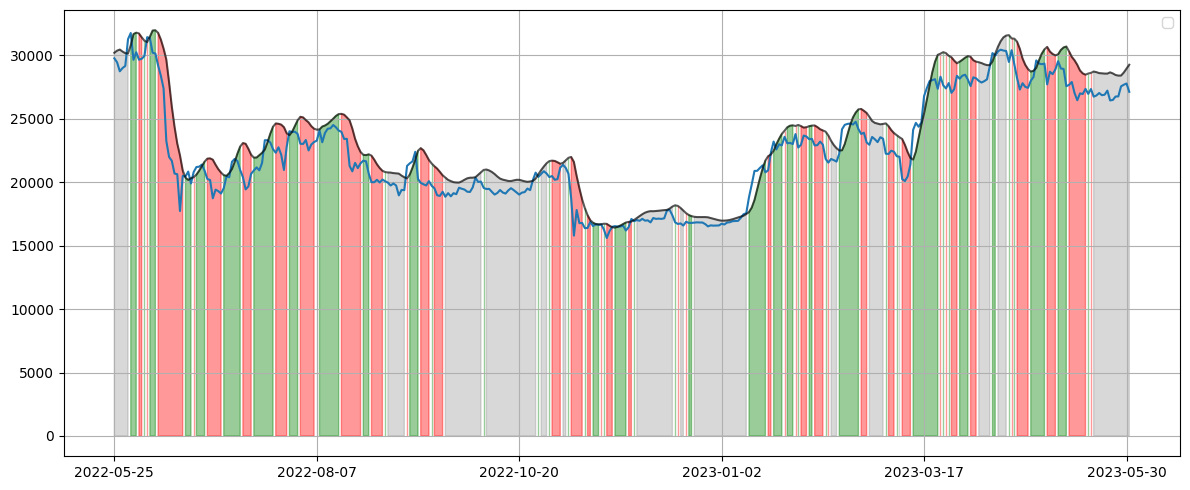

In [ ]:
####################
######  Plots ######
####################

# Plot price vs. date regime shifts in
plt.figure(figsize=(12, 5))
plt.plot(original['Date'][3:], original['Actual'][3:]);
plt.plot(original['Date'][3:], predicted['Predicted'][3:], color='black', alpha=0.65);

plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Bull' for r in regimes], color='green', alpha=0.4);
plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Bear' for r in regimes], color='red', alpha=0.4);
plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Neutral' for r in regimes], color='grey', alpha=0.3);

N = len(original['Date'][3:]) // 5
xticks = original['Date'][3::N]
plt.xticks(xticks);
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.show();


/tmp/ipython-input-4137138025.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


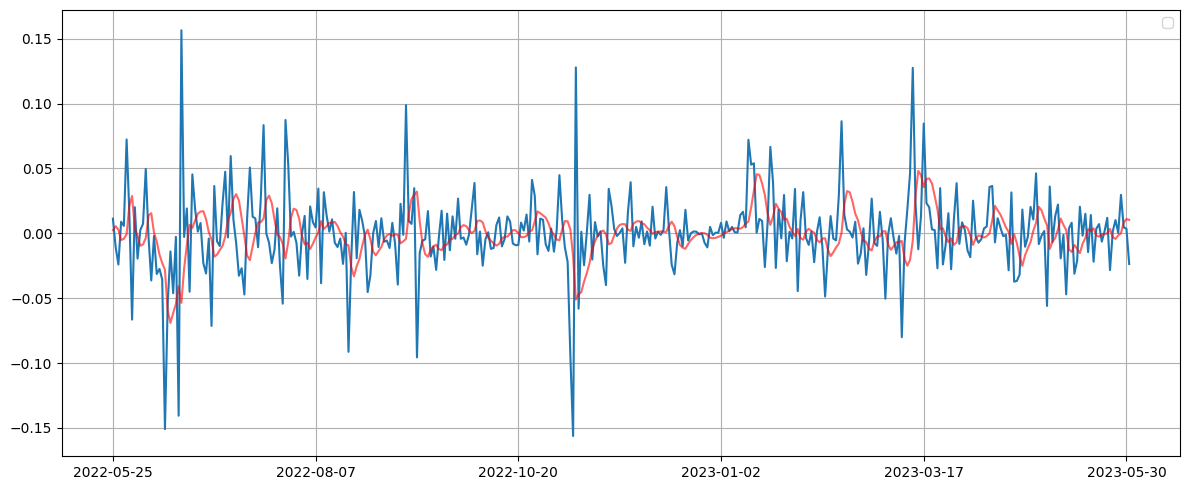

In [ ]:
# Plot regime shift for log returns vs. date
plt.figure(figsize=(12, 5))
plt.plot(original['Date'][3:], original['Returns'][3:])
plt.plot(original['Date'][3:], predicted['Returns'][3:], color='red', alpha=0.6)

N = len(original['Date'][3:]) // 5
xticks = original['Date'][3::N]
plt.xticks(xticks);

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


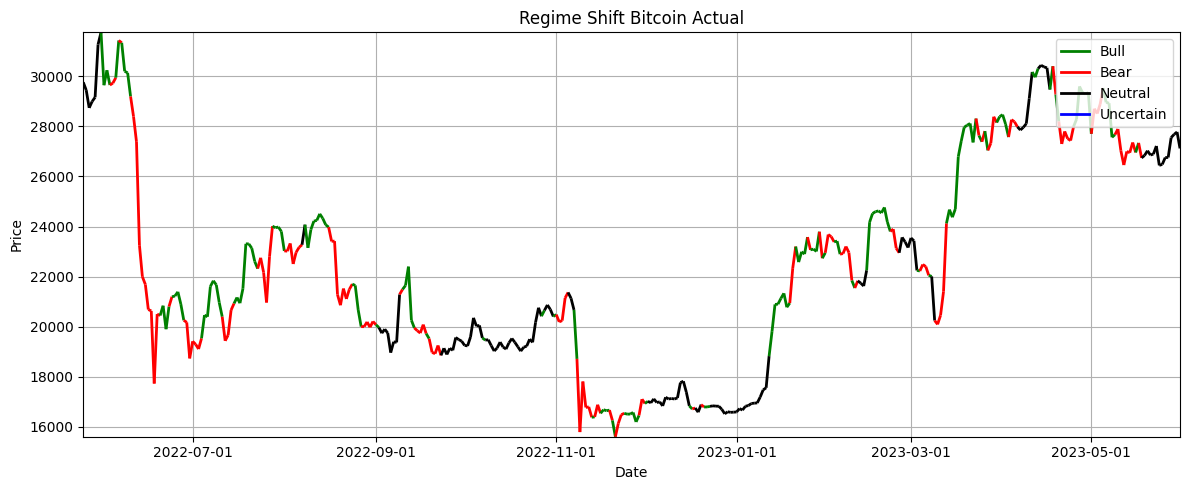

In [ ]:
# Plot price vs. date regime shift
# Select dates, prices values and convert to matplotlib format
# Plot each segment
dates = pd.to_datetime(original['Date'][3:])
prices = original['Actual'][3:].values
x = mdates.date2num(dates)
points = np.array([x, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map each regime to color & add legend to plot
color_map = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'black', 'Uncertain':'blue'}
colors = [color_map.get(r, 'black') for r in regimes[:len(segments)]]
legend = [
    Line2D([0], [0], color='green', lw=2, label='Bull'),
    Line2D([0], [0], color='red', lw=2, label='Bear'),
    Line2D([0], [0], color='black', lw=2, label='Neutral'),
    Line2D([0], [0], color='blue', lw=2, label='Uncertain')
]


# Plot Lineplot with date range from above/legend
fig, ax = plt.subplots(figsize=(12, 5))
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(prices.min(), prices.max())
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)

ax.legend(handles=legend)
ax.set_title("Regime Shift Bitcoin Actual")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

plt.grid(True)
plt.tight_layout()
plt.show()


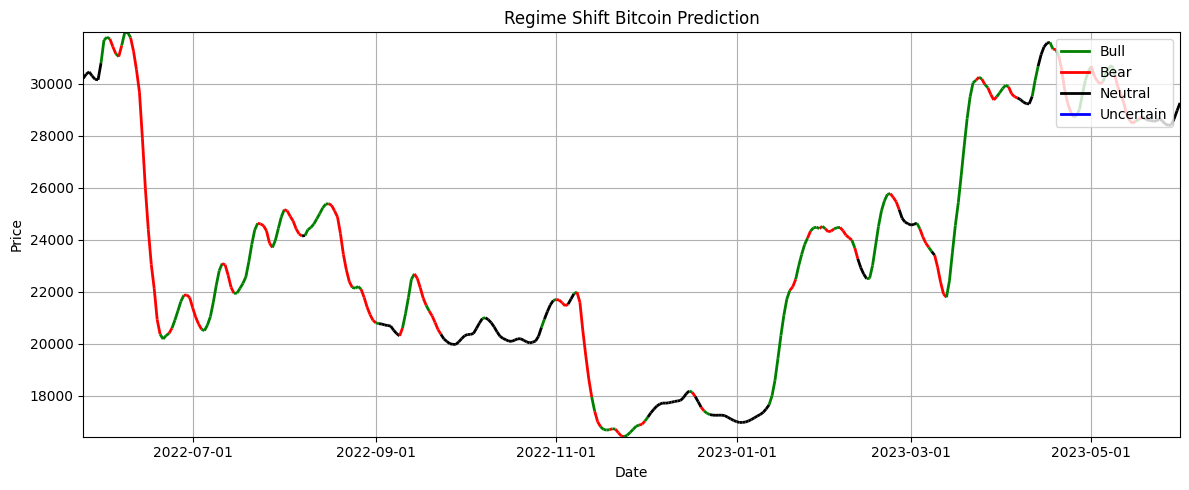

In [ ]:
# Plot price vs. date regime shift

# Select dates, prices values and convert to matplotlib format
# Plot each segment
dates = pd.to_datetime(original['Date'][3:])
prices = predicted['Predicted'][3:].values
x = mdates.date2num(dates)
points = np.array([x, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map each regime to color & add legend to plot
color_map = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'black', 'Uncertain':'blue'}
colors = [color_map.get(r, 'black') for r in regimes[:len(segments)]]
legend = [
    Line2D([0], [0], color='green', lw=2, label='Bull'),
    Line2D([0], [0], color='red', lw=2, label='Bear'),
    Line2D([0], [0], color='black', lw=2, label='Neutral'),
    Line2D([0], [0], color='blue', lw=2, label='Uncertain')
]


# Plot Lineplot with date range from above/legend
fig, ax = plt.subplots(figsize=(12, 5))
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(prices.min(), prices.max())
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)

ax.legend(handles=legend)
ax.set_title("Regime Shift Bitcoin Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

plt.grid(True)
plt.tight_layout()
plt.show()
